In [ ]:
!rm -r AI2022MA/
!git clone https://github.com/UmbertoJr/AI2022MA.git

Cloning into 'AI2022MA'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 356 (delta 31), reused 73 (delta 16), pack-reused 265
Receiving objects: 100% (356/356), 13.21 MiB | 2.27 MiB/s, done.
Resolving deltas: 100% (161/161), done.


# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

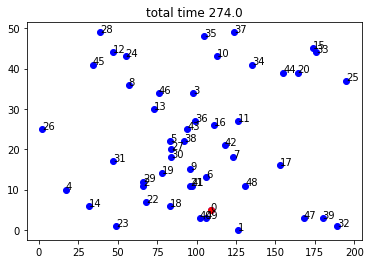

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [ ]:
import numpy as np
from AI2022MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

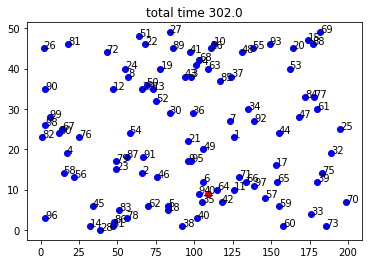

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [ ]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

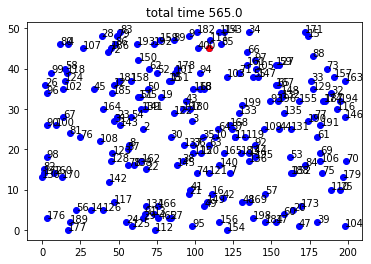

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [ ]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


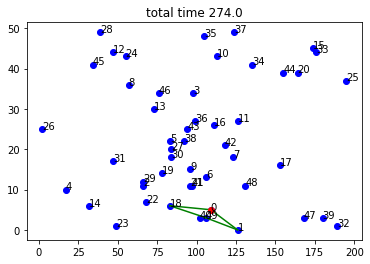

In [ ]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


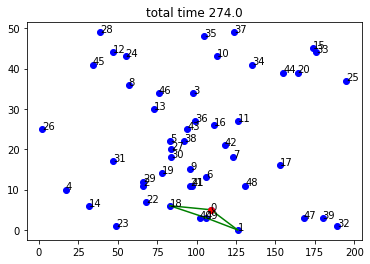

In [ ]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [ ]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}                                                        # nodes already expanded during the search
      if len(self.expandables) == 0:
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far,c=1/(2**0.5)):
      # computes the Upper Confidence Bound for the Node

      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                   best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) /
                                                  self.num_of_visit) ** 0.5
      #self.score = (self.estimated_reward/ self.num_of_visit)+ c * ((2*np.log(self.parent.num_of_visit) / self.num_of_visit) ** 0.5)

      #print("TEST")
      #print("score",self.score)
      #print("estimated_reward",self.estimated_reward)
      #print("num_visit",self.num_of_visit)
      #print("current_reward",self.current_reward)
      #print("best_reward_so_far",best_reward_so_far)
      #print("parent.num_of_visit",self.parent.num_of_visit)

    def calculateScore(self, best_reward_so_far,c=1/(2**0.5)):
      # computes the Upper Confidence Bound for the Node
      #c=1/(2**0.5)
      #self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
      #             best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) /
      #                                            self.num_of_visit) ** 0.5
      self.score = (self.estimated_reward/ self.num_of_visit)+ c * ((2*np.log(self.parent.num_of_visit) / self.num_of_visit) ** 0.5)






### MCTS

In [ ]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


class MCTS:
  def __init__(self, env,time_limit, initial_path,test,c):
    self.c=c
    self.test=test
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0,
                     expandable_customers = ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    while not node.terminal:
      if not node.fully_expanded:
          return self.expand(node)
      else:
          node = self.selectBestChild(node)
    return node



  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score.
    """

    best_score = 0
    best_child = None
    # TO DO

    for child in node.expanded.values():
      if(self.test):
        child.calculateScore(self.max_reward,self.c)
      else:
        child.calculateUCTscore(self.max_reward,self.c)


      score = child.score
      if score > best_score:
          best_score = score
          best_child = child
    return best_child



  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)

    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward,
                           expandable_customers=ordered_list)

    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True

    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4]
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))

      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])

    _, new_r, _ = self.env.check_solution(new_path)
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward


  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node is not None:
        node.num_of_visit += 1
        node.estimated_reward += reward_esteem
        node = node.parent


  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

instance_number 0
seed 111
(274.0, 1.83, True)


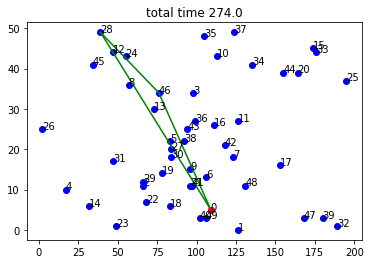

seed 222
(274.0, 1.4700000000000002, True)


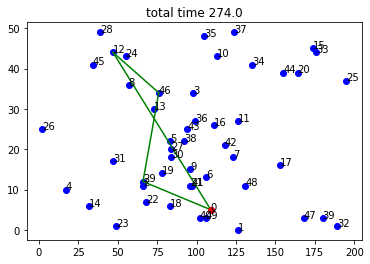

seed 333
(274.0, 1.78, True)


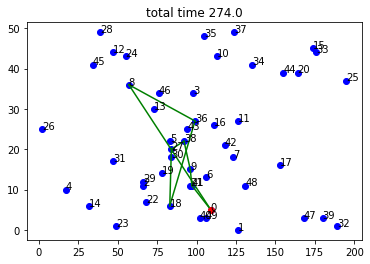

instance_number 1
seed 111
(302.0, 1.73, True)


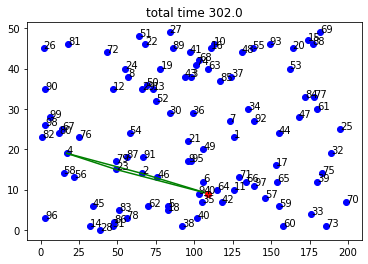

seed 222
(302.0, 1.5899999999999999, True)


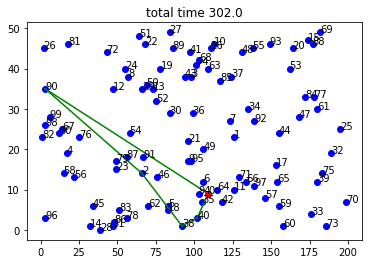

seed 333
(302.0, 1.85, True)


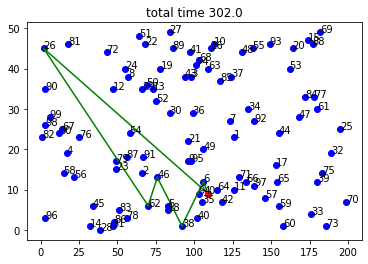

instance_number 2
seed 111
(565.0, 2.5300000000000002, True)


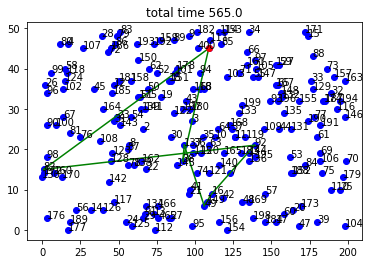

seed 222
(565.0, 2.4699999999999998, True)


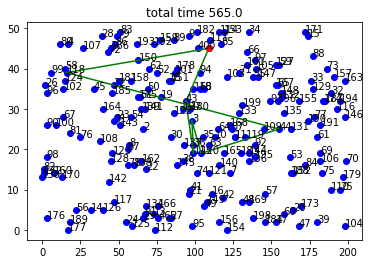

seed 333
(565.0, 3.25, True)


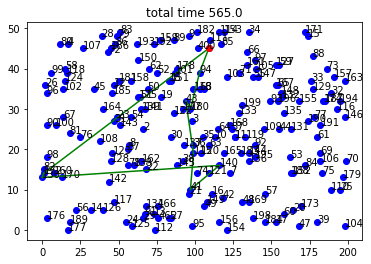

In [ ]:
import sys

instance_numbers = [0,1,2]
seeds = [111,222,333]
test = False
c = 1/(2**0.5)
best_sol = None
time_limit = 5
results_base=[]
for instance_number in instance_numbers:
  print("instance_number",instance_number)
  for seed in seeds:
    print("seed",seed)
    env = Env(from_file=True, instance_number=instance_number,seed=seed)

    #print("seed",seed)
    #print("test=",test)
    #print("c=",c)
    sol = [0]
    best_sol = None
    best_r = 0
    while True:
      mcts = MCTS(env, time_limit, sol,test,c)
      mcts.best_tour_so_far = best_sol
      mcts.max_reward = best_r
      new_customer = mcts.step()
      # print("a new customer is", new_customer)
      sol.append(new_customer)
      if mcts.max_reward > best_r:
        best_r = mcts.max_reward
        best_sol = mcts.best_tour_so_far

      if sol[-1] == 0:
        break

    results_base.append((instance_number,seed,test,c,env.check_solution(best_sol)))



    #print("test=",test)
    #print("c=",c)
    #print(env.check_solution(sol))
    #plot_instance(env.x, sol)
    print(env.check_solution(best_sol))
    plot_instance(env.x, best_sol)

In [ ]:
import pandas as pd
pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)
# Create a dataframe from the results list
results_base_df = pd.DataFrame(results_base, columns=["i_n","seed","test","c","sol"])

# Print the results table
print(results_base_df)

   i_n  seed   test         c                                sol
0    0   111  False  0.707107                (274.0, 1.83, True)
1    0   222  False  0.707107  (274.0, 1.4700000000000002, True)
2    0   333  False  0.707107                (274.0, 1.78, True)
3    1   111  False  0.707107                (302.0, 1.73, True)
4    1   222  False  0.707107  (302.0, 1.5899999999999999, True)
5    1   333  False  0.707107                (302.0, 1.85, True)
6    2   111  False  0.707107  (565.0, 2.5300000000000002, True)
7    2   222  False  0.707107  (565.0, 2.4699999999999998, True)
8    2   333  False  0.707107                (565.0, 3.25, True)


instance_number 0
seed 111
(274.0, 2.13, True)


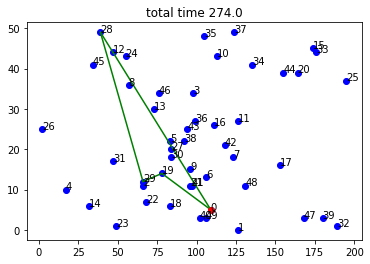

(274.0, 1.83, True)


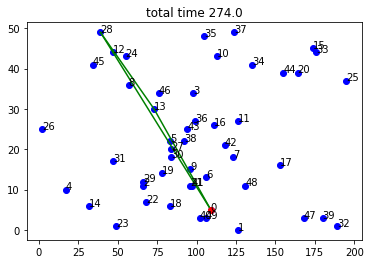

seed 222
(274.0, 1.55, True)


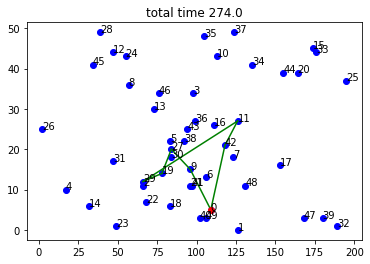

(274.0, 1.73, True)


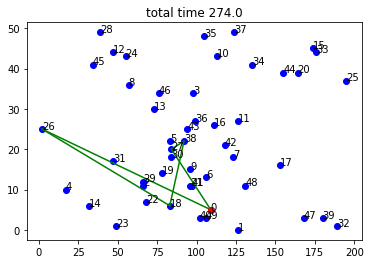

seed 333
(274.0, 1.9700000000000002, True)


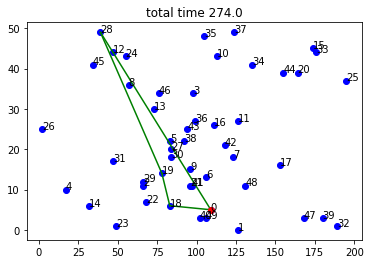

(274.0, 1.51, True)


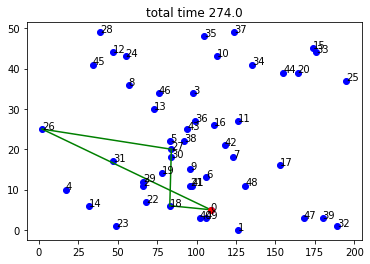

instance_number 1
seed 111
(302.0, 1.4700000000000002, True)


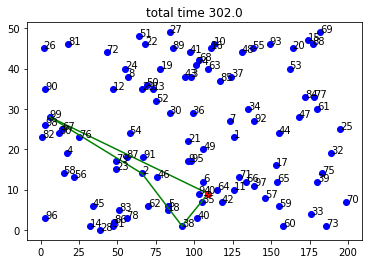

(302.0, 1.35, True)


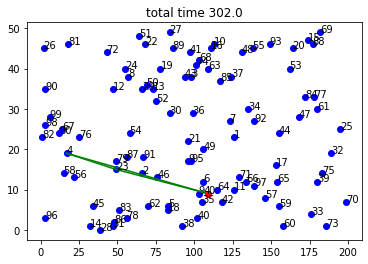

seed 222
(302.0, 1.35, True)


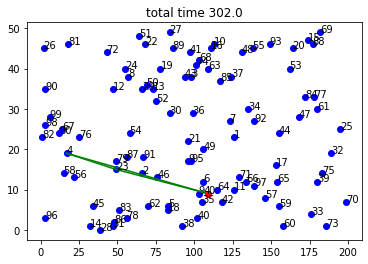

(302.0, 1.59, True)


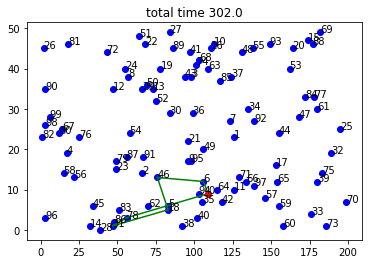

seed 333
(302.0, 1.7, True)


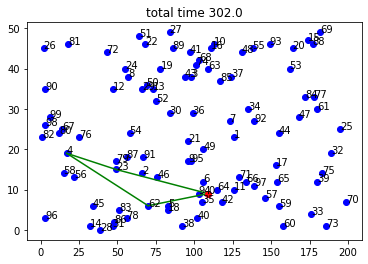

(302.0, 1.7200000000000002, True)


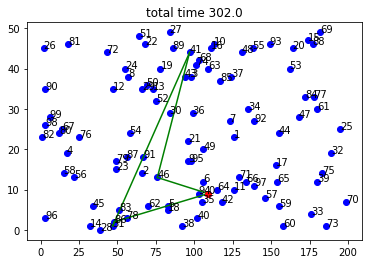

instance_number 2
seed 111
(565.0, 2.5, True)


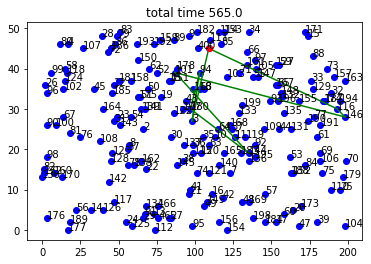

(565.0, 2.74, True)


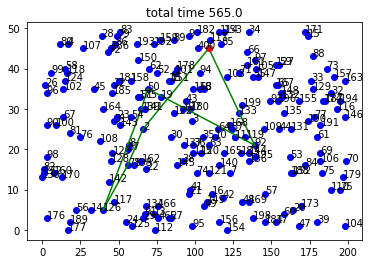

seed 222
(565.0, 2.04, True)


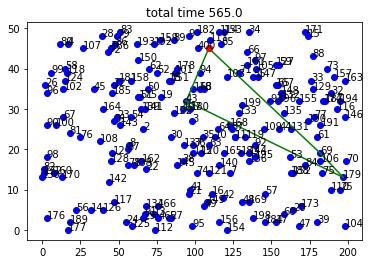

(565.0, 2.8200000000000003, True)


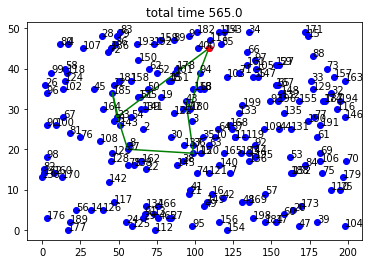

seed 333
(565.0, 2.9699999999999998, True)


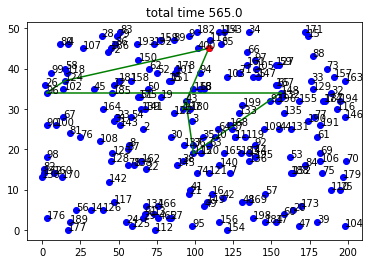

(565.0, 2.51, True)


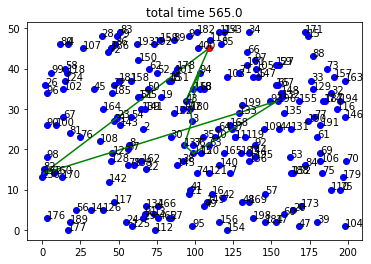

In [ ]:
#TEST with different values of c (exploration/exploitation), and a different function to select best child
import sys

instance_numbers = [0,1,2]
seeds = [111,222,333]
tests = [True,False]
cs = [0.1,0.25,0.5,0.75,1]
best_sol = None
time_limit = 5
results_test=[]
for instance_number in instance_numbers:
  print("instance_number",instance_number)
  for seed in seeds:
    print("seed",seed)
    env = Env(from_file=True, instance_number=instance_number,seed=seed)
    for test in tests:
      for c in cs:
        #print("seed",seed)
        #print("test=",test)
        #print("c=",c)
        #env = Env(from_file=True, instance_number=instance_number,seed=seed)
        #time_limit = 5
        sol = [0]
        best_sol = None
        best_r = 0
        #best_r = sys.float_info.min
        while True:
          mcts = MCTS(env, time_limit, sol,test,c)
          mcts.best_tour_so_far = best_sol
          mcts.max_reward = best_r
          new_customer = mcts.step()
          # print("a new customer is", new_customer)
          sol.append(new_customer)
          if mcts.max_reward > best_r:
            best_r = mcts.max_reward
            best_sol = mcts.best_tour_so_far

          if sol[-1] == 0:
            break

        results_test.append((instance_number,seed,test,c,env.check_solution(best_sol)))



      #print("test=",test)
      #print("c=",c)
      #print(env.check_solution(sol))
      #plot_instance(env.x, sol)
      print(env.check_solution(best_sol))
      plot_instance(env.x, best_sol)

In [ ]:
import pandas as pd
pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)
# Create a dataframe from the results list
results_df = pd.DataFrame(results_test, columns=["i_n","seed","test","c","sol"])

# Print the results table
print(results_df)

    i_n  seed   test     c                                sol
0     0   111   True  0.10                (274.0, 1.83, True)
1     0   111   True  0.25  (274.0, 1.7999999999999998, True)
2     0   111   True  0.50  (274.0, 1.8899999999999997, True)
3     0   111   True  0.75                (274.0, 2.47, True)
4     0   111   True  1.00                (274.0, 2.13, True)
5     0   111  False  0.10                (274.0, 1.94, True)
6     0   111  False  0.25  (274.0, 1.7200000000000002, True)
7     0   111  False  0.50                (274.0, 2.07, True)
8     0   111  False  0.75                (274.0, 1.73, True)
9     0   111  False  1.00                (274.0, 1.83, True)
10    0   222   True  0.10  (274.0, 1.4700000000000002, True)
11    0   222   True  0.25                (274.0, 1.83, True)
12    0   222   True  0.50                (274.0, 1.63, True)
13    0   222   True  0.75                (274.0, 1.71, True)
14    0   222   True  1.00                (274.0, 1.55, True)
15    0 